# Predicting Water Levels for the Auser Aquifer

## Importing libraries and dataset

In [1]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
aus = pd.read_csv('Aquifer_Auser.csv')

## Performing the same initial transformations as the first notebook

In [3]:
aus['Date'] = pd.to_datetime(aus['Date'], format='%d/%m/%Y')

In [4]:
abs_cols = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
           'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']
# absolute values can be taken from the above columns as clarified by competition host in a discussion thread on kaggle

In [5]:
for col in abs_cols:
    aus[col] = abs(aus[col])

## Further EDA, Cleaning and Feature Engineering

As observed in the first notebook: 

- Values for the features of Volume CSA & CSAL from before 2014 were all zeros. Since these features are independent variables to be used as predictors, only data from 2014 onwards will be used.


- Temperature Ponte a Moriano contains 0 values from 2017 onwards indicating that the field instrument failed and wasn't replaced/repaired. This feature will be dropped.


- Some 0 values and null values were observed in most of the features. 0 values are taken to be instrument failures and are thus replaced with null and subsequently filled by interpolation.

In [6]:
aus = aus.loc[aus['Date'] >= '01/01/2014']
aus.drop('Temperature_Ponte_a_Moriano', axis=1, inplace=True)
aus.reset_index(inplace=True, drop=True)

In [7]:
null_0_cols = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC', 'Depth_to_Groundwater_LT2',
       'Hydrometry_Monte_S_Quirico',
       'Hydrometry_Piaggione']

In [8]:
for col in null_0_cols:
    aus[col] = aus[col].replace(0, np.nan)

In [9]:
for col in null_0_cols:
    aus[col] = aus[col].interpolate()

In [10]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     2373 non-null   datetime64[ns]
 1   Rainfall_Gallicano                       2373 non-null   float64       
 2   Rainfall_Pontetetto                      2373 non-null   float64       
 3   Rainfall_Monte_Serra                     2373 non-null   float64       
 4   Rainfall_Orentano                        2373 non-null   float64       
 5   Rainfall_Borgo_a_Mozzano                 2373 non-null   float64       
 6   Rainfall_Piaggione                       2373 non-null   float64       
 7   Rainfall_Calavorno                       2373 non-null   float64       
 8   Rainfall_Croce_Arcana                    2373 non-null   float64       
 9   Rainfall_Tereglio_Coreglia_Antelminelli  

In [11]:
aus[['Depth_to_Groundwater_CoS']].loc[aus['Depth_to_Groundwater_CoS'].isnull()].head()
# interpolate failed as missing values were present in dataset since before 1 Jan 2014.

,Depth_to_Groundwater_CoS
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [12]:
# checking the original dataset, the last value for 'Depth_to_Groundwater_CoS' was on 3 Dec 2013 with a value of 6.36
# the next non-null cell was found on 20 Mar 2014 with a value of 5.41
# value on 1 Jan 2014 is calculated by interpolating manually
aus['Depth_to_Groundwater_CoS'][0] = 6.36-28*(6.36-5.41)/(28+31+28+19)

<ipython-input-12-71775e1be4bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['Depth_to_Groundwater_CoS'][0] = 6.36-28*(6.36-5.41)/(28+31+28+19)


In [13]:
aus['Depth_to_Groundwater_CoS'] = aus['Depth_to_Groundwater_CoS'].interpolate()
# values from 2 Jan 2014 to 19 Mar 2014 can then be filled via the interpolation function

In [14]:
aus.set_index("Date", inplace=True)

In [15]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2014-01-01 to 2020-06-30
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rainfall_Gallicano                       2373 non-null   float64
 1   Rainfall_Pontetetto                      2373 non-null   float64
 2   Rainfall_Monte_Serra                     2373 non-null   float64
 3   Rainfall_Orentano                        2373 non-null   float64
 4   Rainfall_Borgo_a_Mozzano                 2373 non-null   float64
 5   Rainfall_Piaggione                       2373 non-null   float64
 6   Rainfall_Calavorno                       2373 non-null   float64
 7   Rainfall_Croce_Arcana                    2373 non-null   float64
 8   Rainfall_Tereglio_Coreglia_Antelminelli  2373 non-null   float64
 9   Rainfall_Fabbriche_di_Vallico            2373 non-null   float64
 10  Depth_to_Groundwater_LT2      

### Rolling 7 and searching for the best shift

In [16]:
aus_lt2 = aus.copy()
aus_sal = aus.copy()
aus_cos = aus.copy()
# making 3 copies of the dataframe for each of the target variables

#### Best shift for rainfall and temperature features with respect to LT2 Depth

In [17]:
rollers_lt2 = [col for col in aus.columns if "LT2" not in col]

In [18]:
for col in rollers_lt2:
    aus_lt2[col] = aus_lt2[col].rolling(7).mean()
# rolling all columns except the target column to smooth out short-term fluctuations

- Shifting by a range of days since the number of days after that water depths are affected by rainfall and temperatures are unknown. 


- 7 days is the minimum since the model is meant to serve as a week-ahead forecast.


- After each shift, the correlation with the target variable is computed and stored.


- Correlation vs. the number of days shifted is plotted to find the highest correlation.

In [19]:
corr_rain = []
corr_temp = []

for col in rollers_lt2:
    
    if 'Rainfall' in col:
        temporary_rain_corrs = []
        for i in range(7,150):
            temporary_corr = aus_lt2[[col]].shift(i).corrwith(aus_lt2['Depth_to_Groundwater_LT2'])[0]
            temporary_rain_corrs.append(temporary_corr)
        corr_rain.append(temporary_rain_corrs)
             
    if 'Temperature' in col:
        temporary_temp_corrs = []
        for i in range(7,100):
            temporary_corr = aus_lt2[[col]].shift(i).corrwith(aus_lt2['Depth_to_Groundwater_LT2'])[0]
            temporary_temp_corrs.append(temporary_corr)
        corr_temp.append(temporary_temp_corrs)

In [20]:
rain_cols = [col for col in aus.columns if "Rainfall" in col]

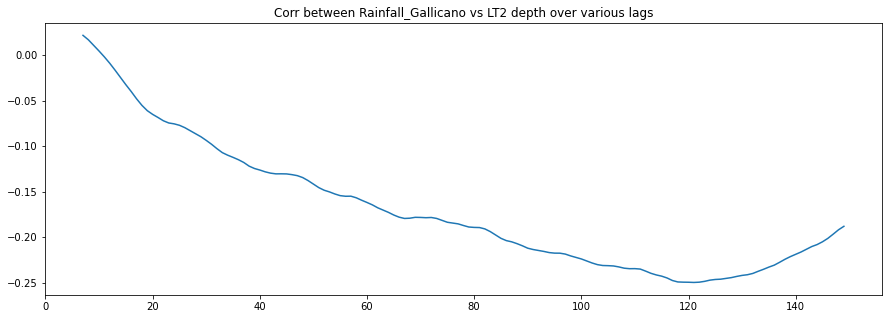

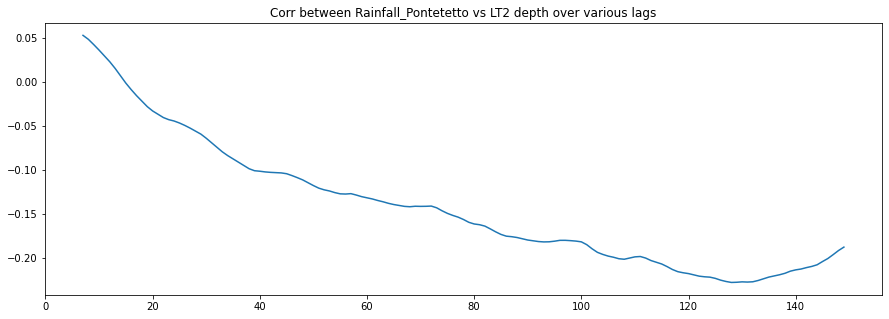

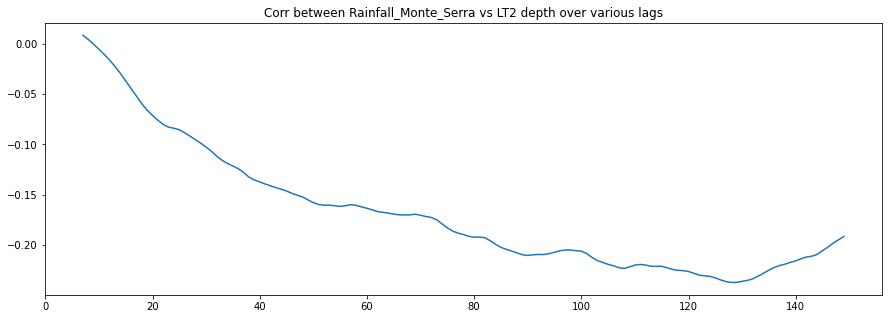

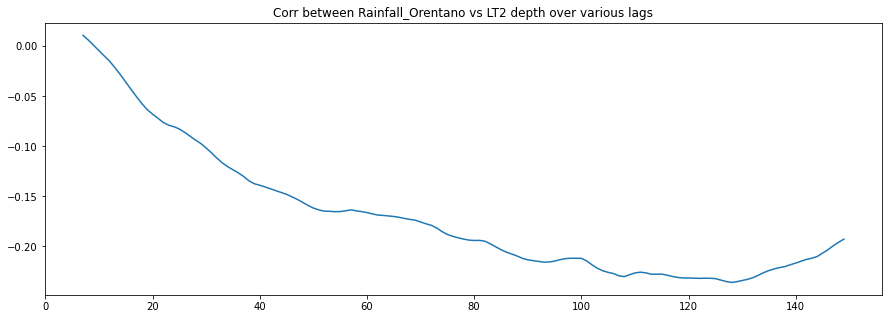

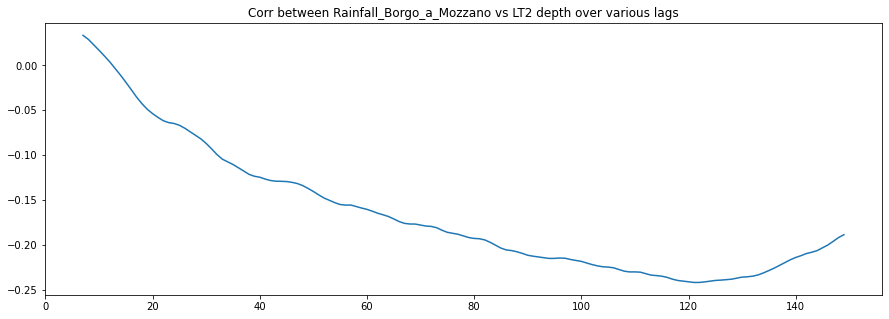

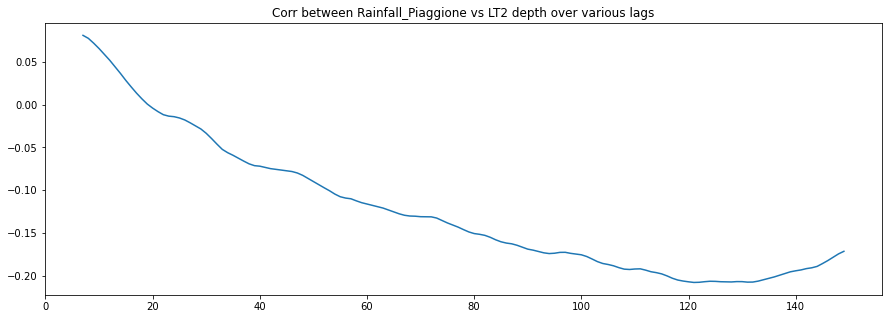

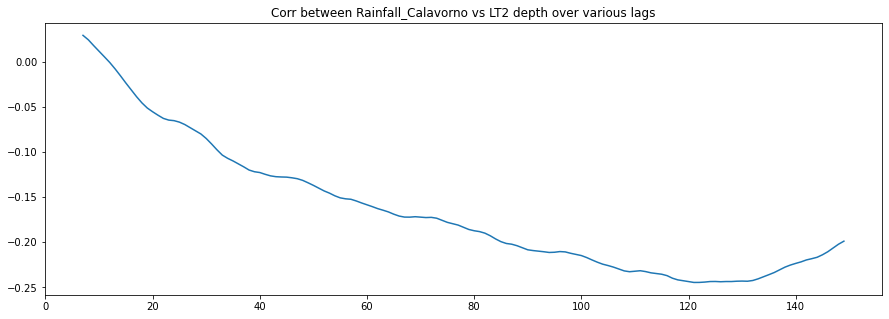

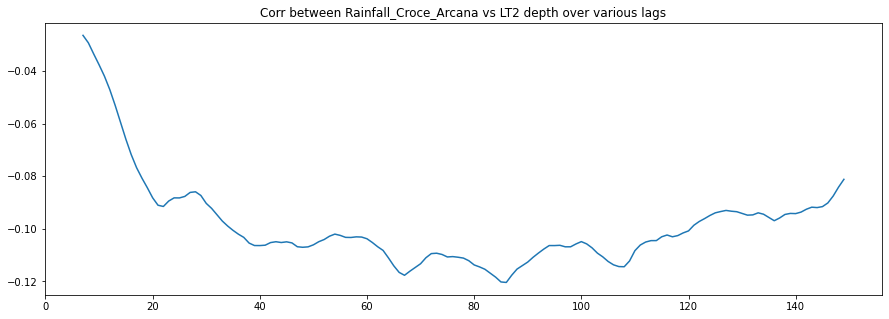

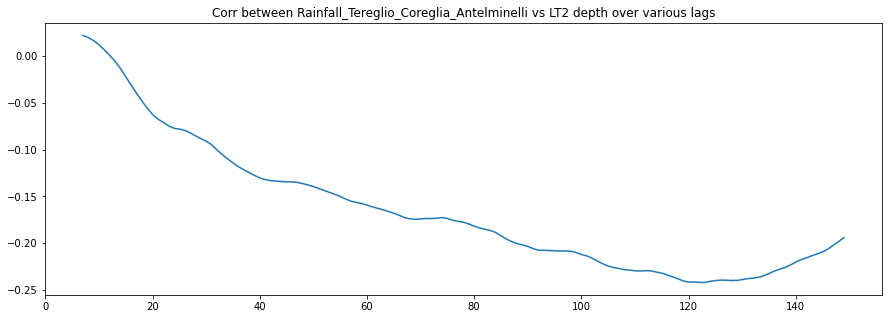

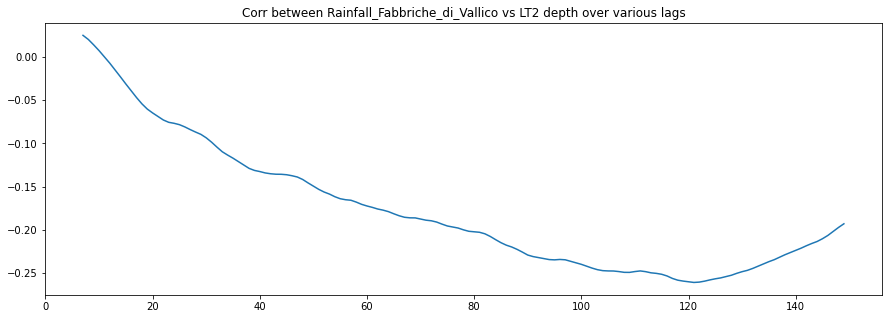

In [21]:
for i in range(len(corr_rain)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,150), corr_rain[i])
    plt.title('Corr between ' +rain_cols[i]+ ' vs LT2 depth over various lags');

In [22]:
temp_cols = [col for col in aus.columns if "Temperature" in col]
temp_cols

['Temperature_Orentano',
 'Temperature_Monte_Serra',
 'Temperature_Lucca_Orto_Botanico']

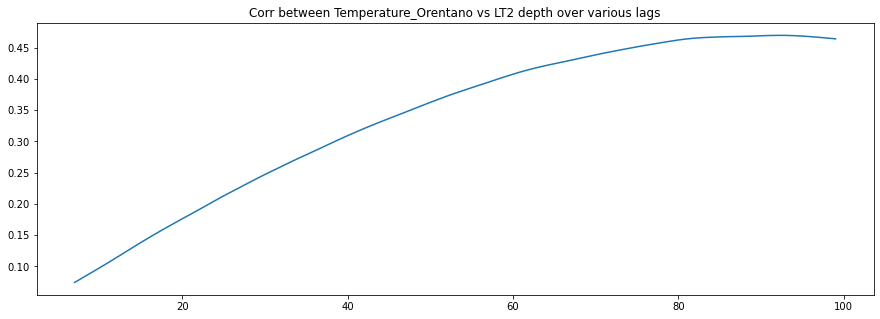

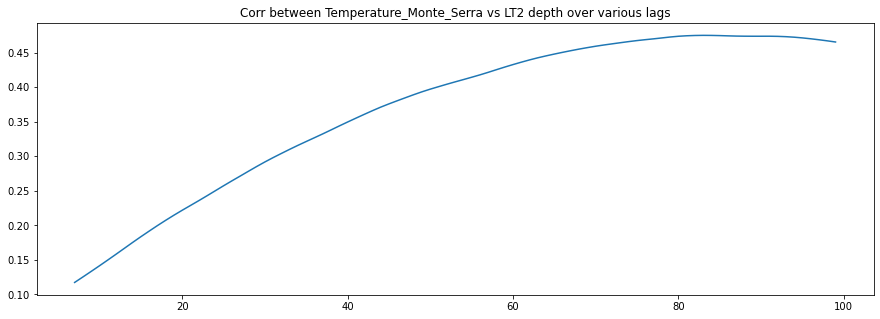

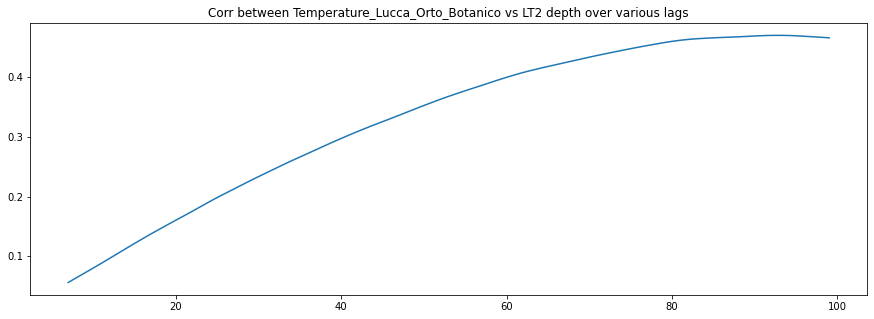

In [23]:
for i in range(len(corr_temp)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,100), corr_temp[i])
    plt.title('Corr between ' +temp_cols[i]+ ' vs LT2 depth over various lags');

- The number of days shifted that corresponds to the highest correlation for each of the rainfall and temperature features is extracted and stored in a dictionary


- The features are then shifted by the number of days that correspond to the highest correlation by iterating over each key-value pair in the dictionary

In [24]:
temp_shifts = {}
for i in range(len(corr_temp)):
    temp_shifts[temp_cols[i]] = corr_temp[i].index(max(corr_temp[i]))+7

rain_shifts = {}
for i in range(len(corr_rain)):
    rain_shifts[rain_cols[i]] = corr_rain[i].index(min(corr_rain[i]))+7

In [25]:
# shifting

for k, v in temp_shifts.items():
    aus_lt2[k] = aus_lt2[k].shift(v)
    
for k, v in rain_shifts.items():
    aus_lt2[k] = aus_lt2[k].shift(v)

All other features are shifted by 7 days since the model is intended to be a week-ahead forecast.

In [26]:
other_cols = [col for col in rollers_lt2 if "Temperature" not in col and "Rainfall" not in col]

for col in other_cols:
    aus_lt2[col]=aus_lt2[col].shift(7)

In [27]:
def heat(df, name):
    mask = np.triu(df.corr());
    plt.figure(figsize=(20,20));
    ax = plt.axes();
    ax.set_title("Heatmap of Corr for " + str(name));
    sns.heatmap(df.corr(), ax=ax, vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, square=True, mask=mask, linewidths=.1, fmt=".2f");

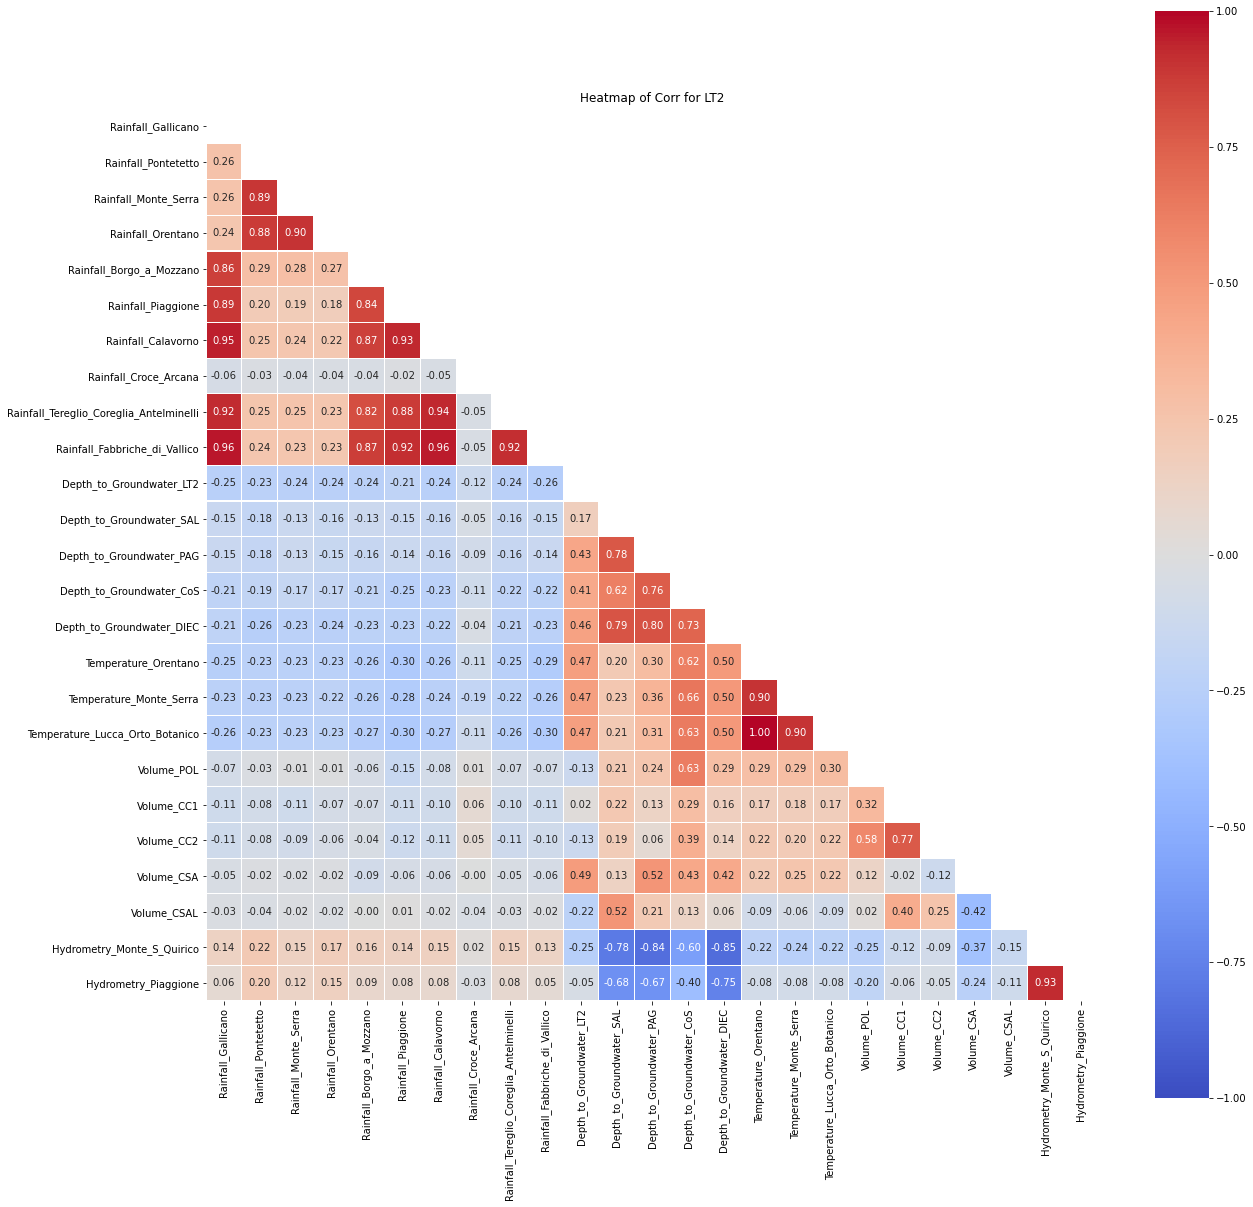

In [28]:
heat(aus_lt2, 'LT2')

- Moderate correlations observed between the targeted variable (Depth at LT2) and the three temperature features, Volume of water drawn at CSA, as well as the depths at a few other locations. Weaker correlations were observed with regards to rainfall.


- Generally, rough shifts of 130 days and 90 days are required for the rainfall and temperature features respectively.

#### Best shift for features with respect to SAL Depth

In [29]:
rollers_sal = [col for col in aus.columns if "Depth_to_Groundwater_SAL" not in col]

In [30]:
for col in rollers_sal:
    aus_sal[col] = aus_sal[col].rolling(7).mean()

The same method is employed to find the optimum number of days to shift with respect to the Depth at SAL

In [31]:
corr_rain = []
corr_temp = []

for col in rollers_sal:
    
    if 'Rainfall' in col:
        temporary_rain_corrs = []
        for i in range(7,30):
            temporary_corr = aus_sal[[col]].shift(i).corrwith(aus_sal['Depth_to_Groundwater_SAL'])[0]
            temporary_rain_corrs.append(temporary_corr)
        corr_rain.append(temporary_rain_corrs)
             
    if 'Temperature' in col:
        temporary_temp_corrs = []
        for i in range(7,30):
            temporary_corr = aus_sal[[col]].shift(i).corrwith(aus_sal['Depth_to_Groundwater_SAL'])[0]
            temporary_temp_corrs.append(temporary_corr)
        corr_temp.append(temporary_temp_corrs)

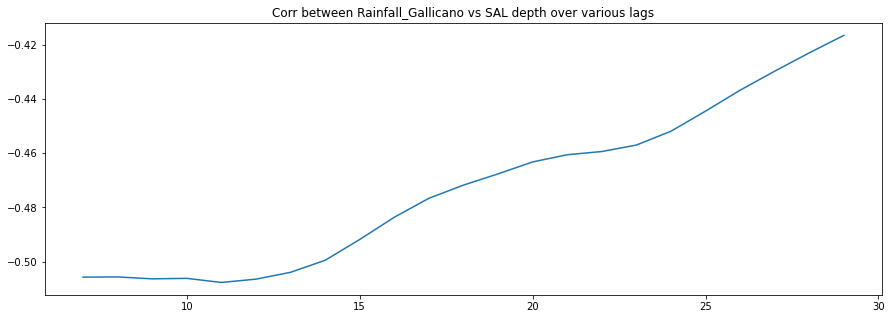

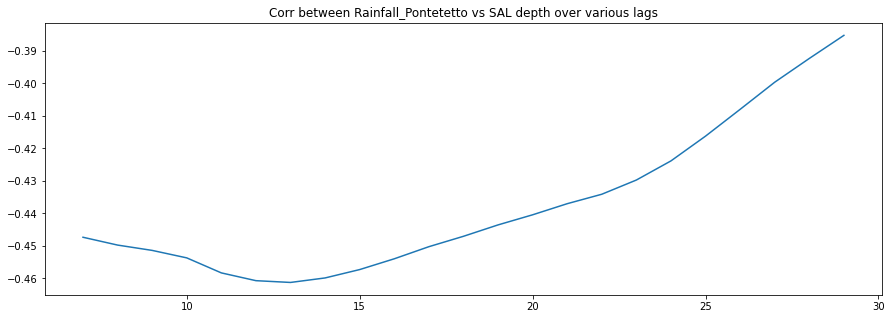

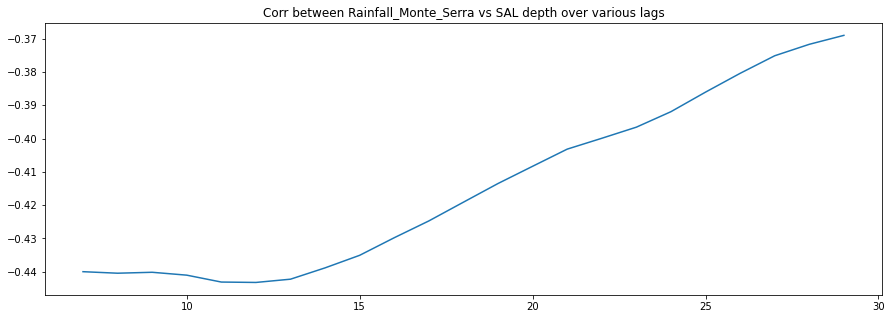

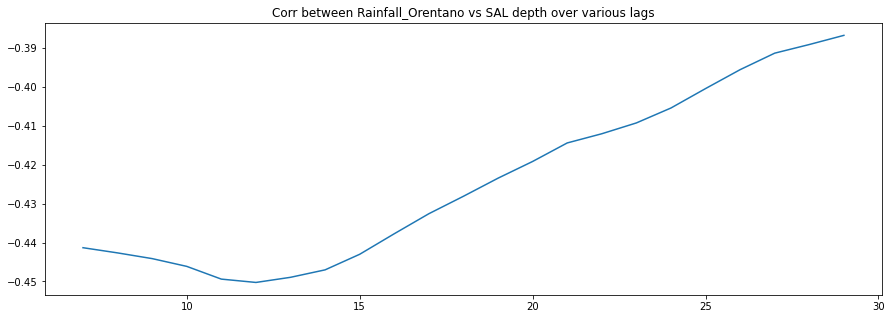

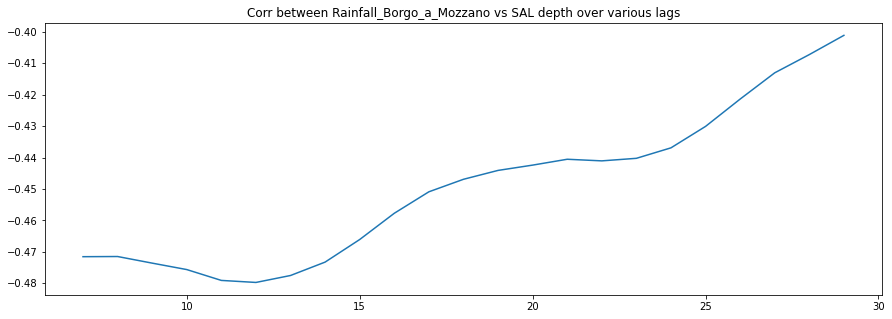

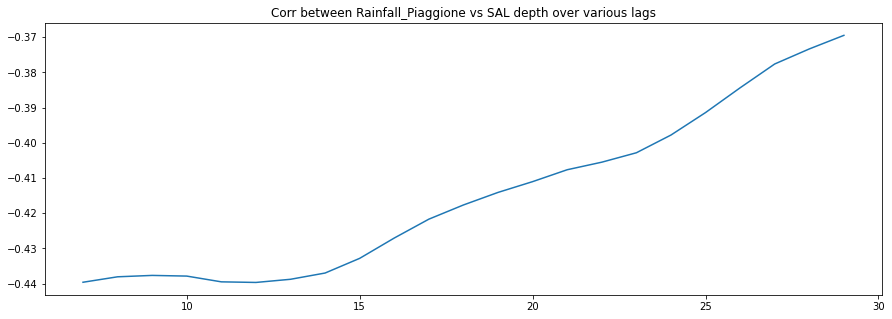

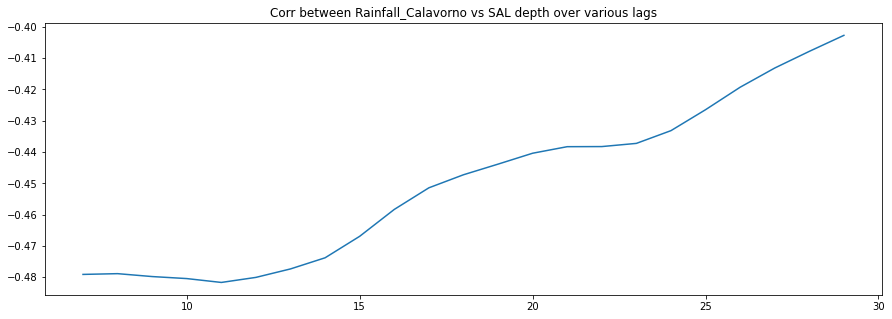

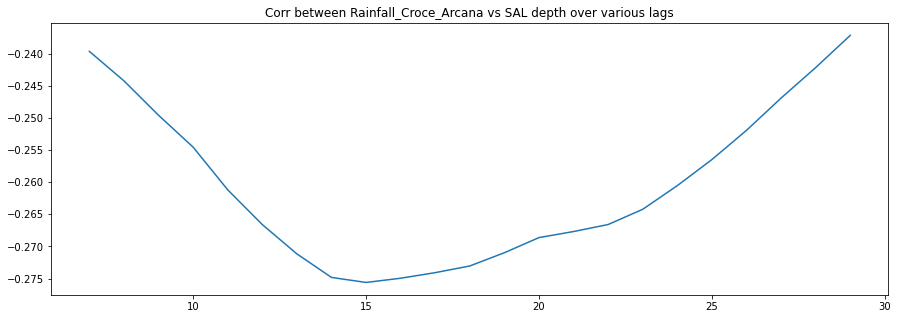

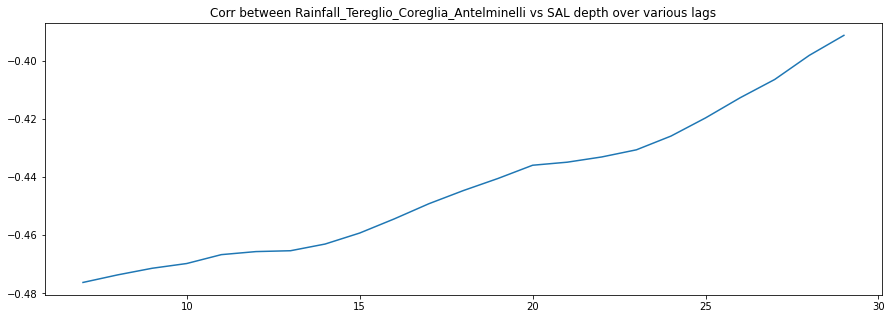

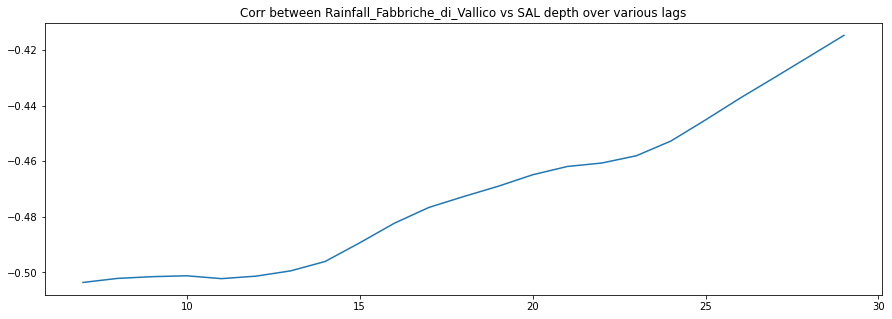

In [32]:
for i in range(len(corr_rain)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,30), corr_rain[i])
    plt.title('Corr between ' +rain_cols[i]+ ' vs SAL depth over various lags');

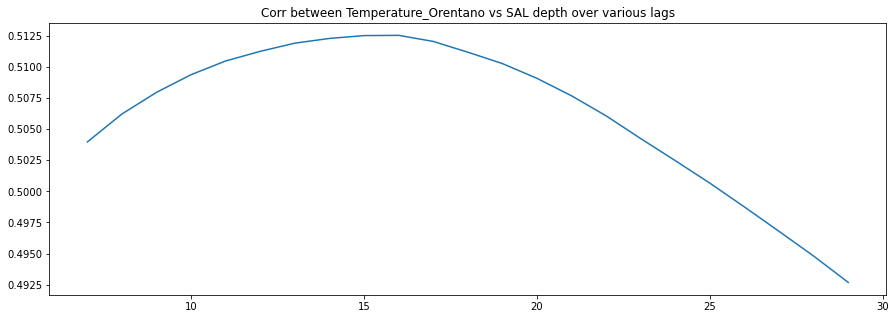

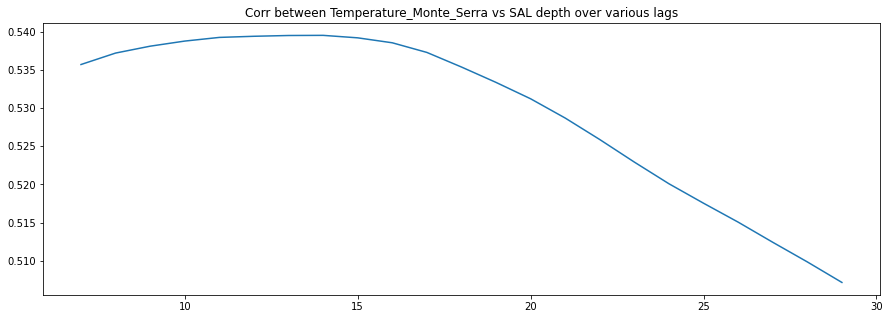

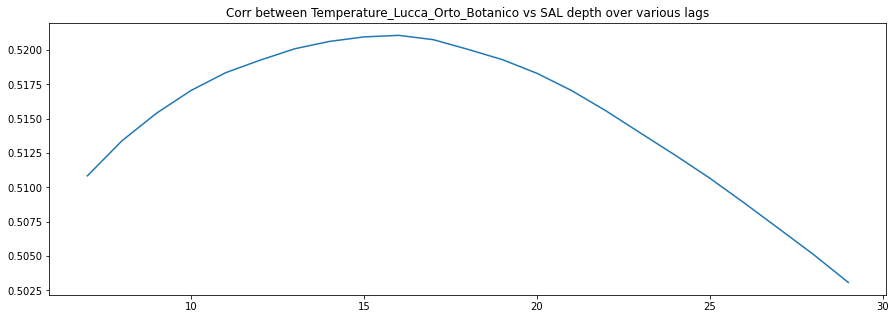

In [33]:
for i in range(len(corr_temp)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,30), corr_temp[i])
    plt.title('Corr between ' +temp_cols[i]+ ' vs SAL depth over various lags');

In [34]:
temp_shifts = {}
for i in range(len(corr_temp)):
    temp_shifts[temp_cols[i]] = corr_temp[i].index(max(corr_temp[i]))+7

rain_shifts = {}
for i in range(len(corr_rain)):
    rain_shifts[rain_cols[i]] = corr_rain[i].index(min(corr_rain[i]))+7 

In [35]:
for k, v in temp_shifts.items():
    aus_sal[k] = aus_sal[k].shift(v)
    
for k, v in rain_shifts.items():
    aus_sal[k] = aus_sal[k].shift(v)

In [36]:
other_cols = [col for col in rollers_lt2 if "Temperature" not in col and "Rainfall" not in col]

for col in other_cols:
    aus_sal[col]=aus_sal[col].shift(7)

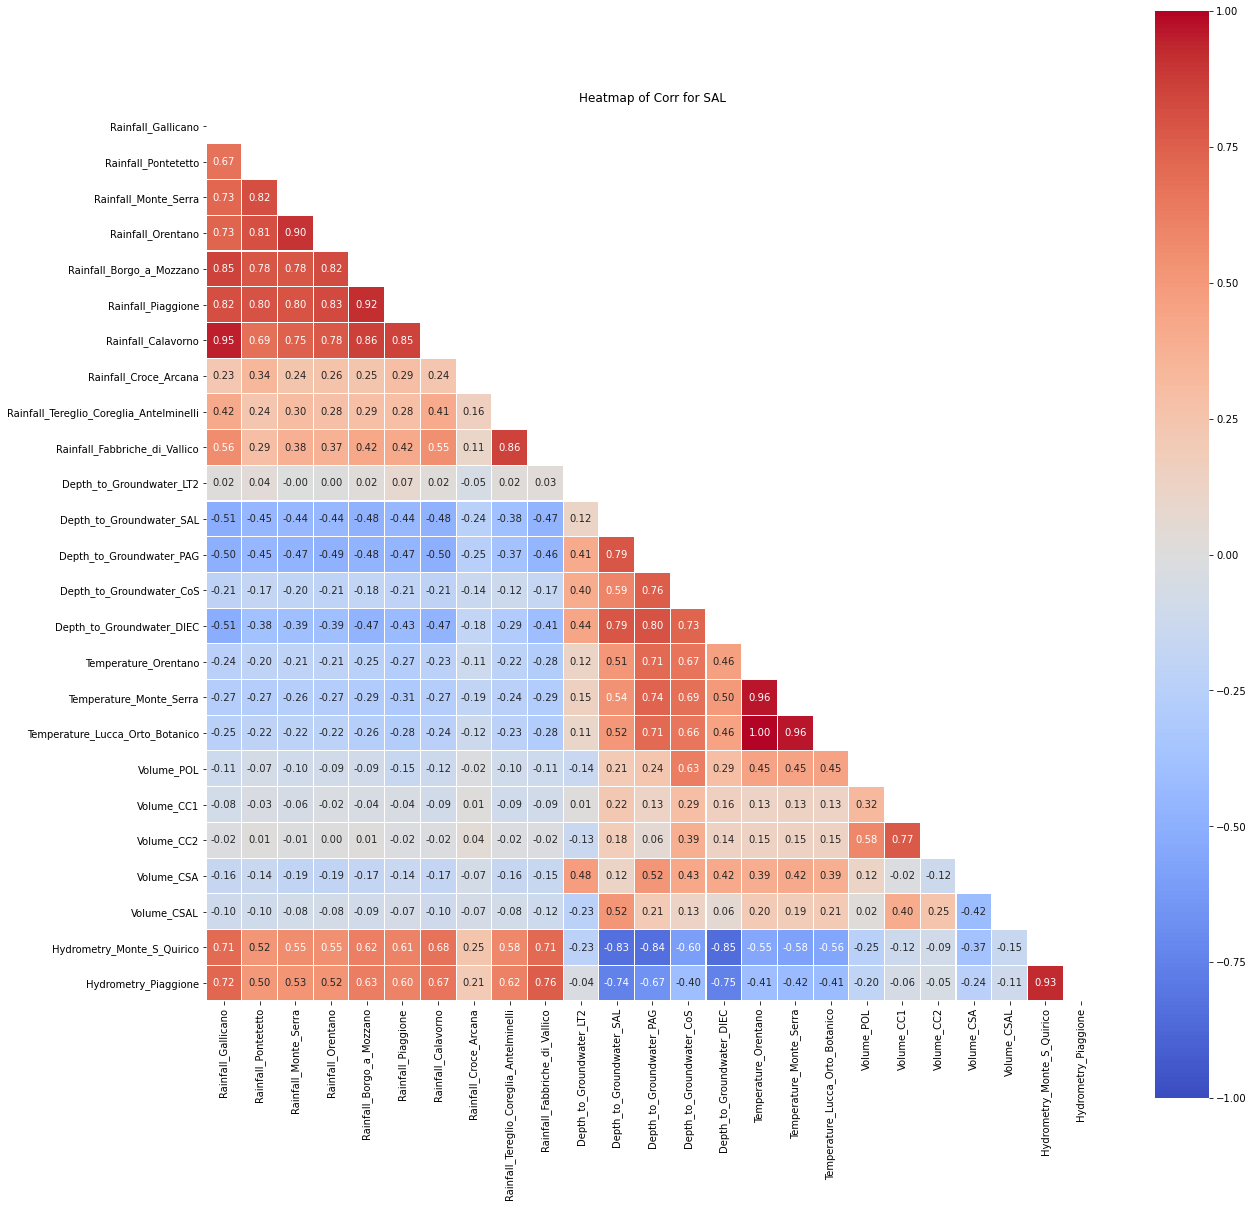

In [37]:
heat(aus_sal, 'SAL')

- The number of days that the data needs to be shifted by is significantly shorter with Depth at SAL as the targeted variable. Most of the features require a shift of around 15 days.


- Depth at SAL correlates well with the hydrometry readings, and the depths at other locations except LT2. Moderate correlations were also observed with most of the temperature and rainfall features as well as the Volume of water drawn at CSAL.

#### Best shift for features with respect to CoS Depth

In [38]:
rollers_cos = [col for col in aus.columns if "Depth_to_Groundwater_CoS" not in col]

In [39]:
for col in rollers_cos:
    aus_cos[col] = aus_cos[col].rolling(7).mean()

The same method is employed to find the optimum number of days to shift with respect to the Depth at CoS

In [40]:
corr_rain = []
corr_temp = []

for col in rollers_cos:
    
    if 'Rainfall' in col:
        temporary_rain_corrs = []
        for i in range(7,60):
            temporary_corr = aus_cos[[col]].shift(i).corrwith(aus_cos['Depth_to_Groundwater_CoS'])[0]
            temporary_rain_corrs.append(temporary_corr)
        corr_rain.append(temporary_rain_corrs)
             
    if 'Temperature' in col:
        temporary_temp_corrs = []
        for i in range(7,60):
            temporary_corr = aus_cos[[col]].shift(i).corrwith(aus_cos['Depth_to_Groundwater_CoS'])[0]
            temporary_temp_corrs.append(temporary_corr)
        corr_temp.append(temporary_temp_corrs)

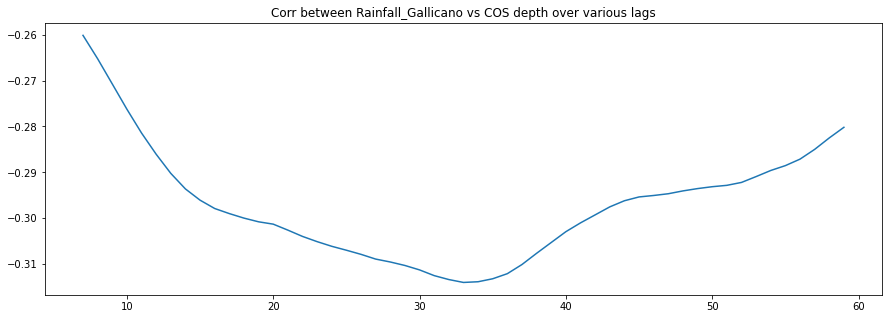

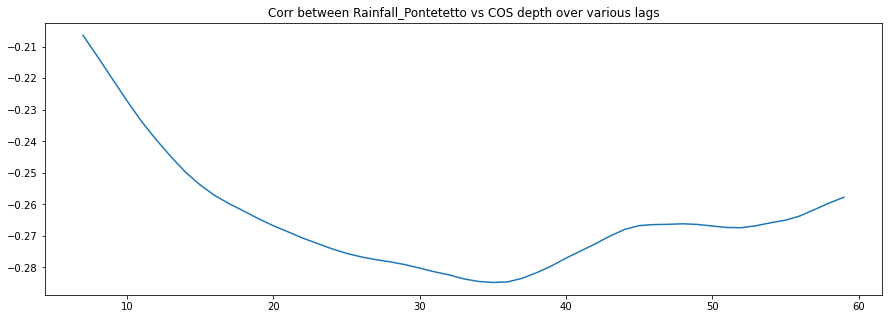

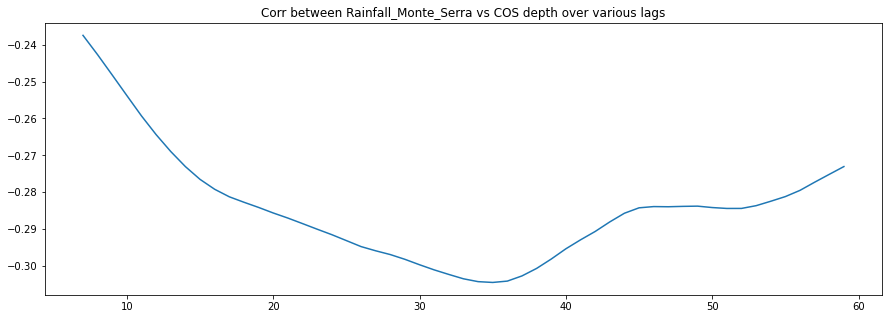

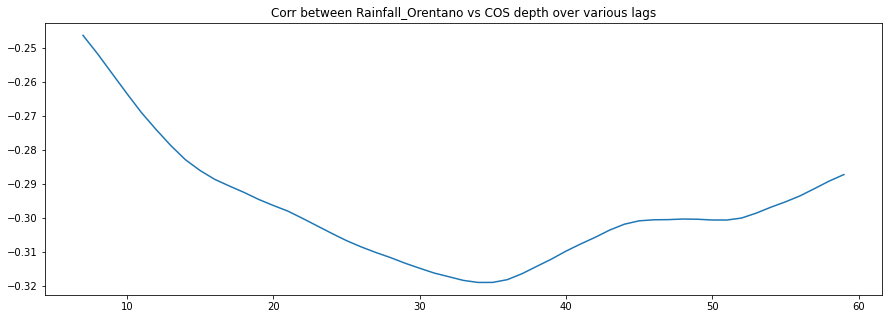

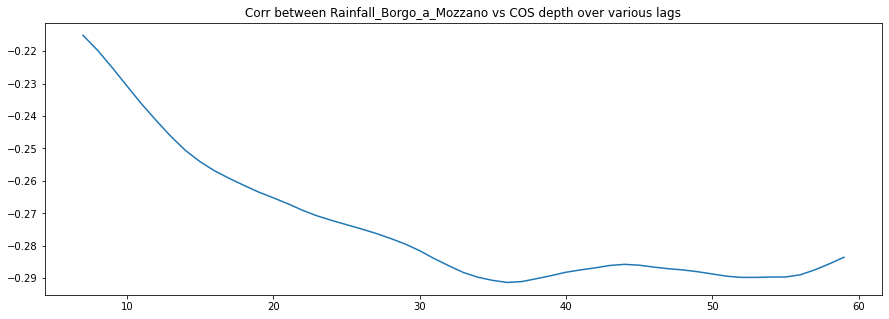

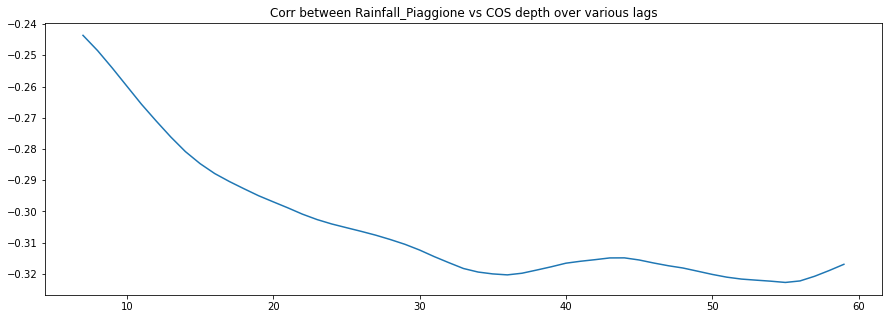

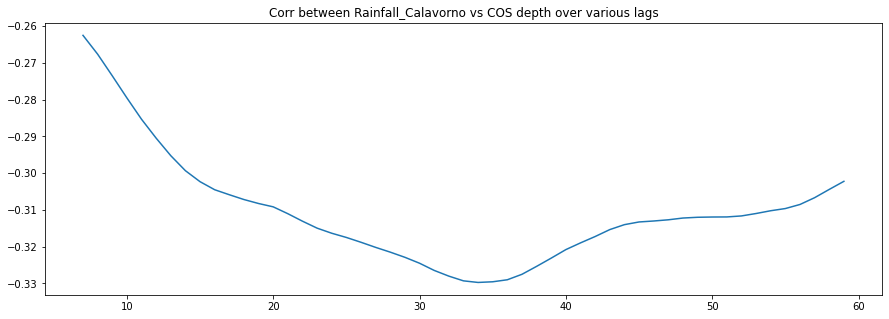

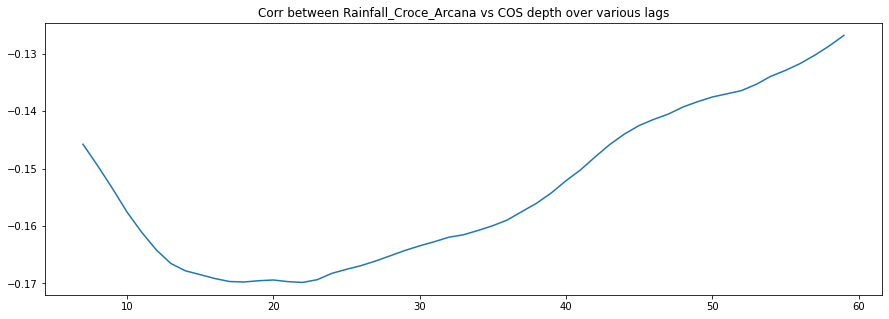

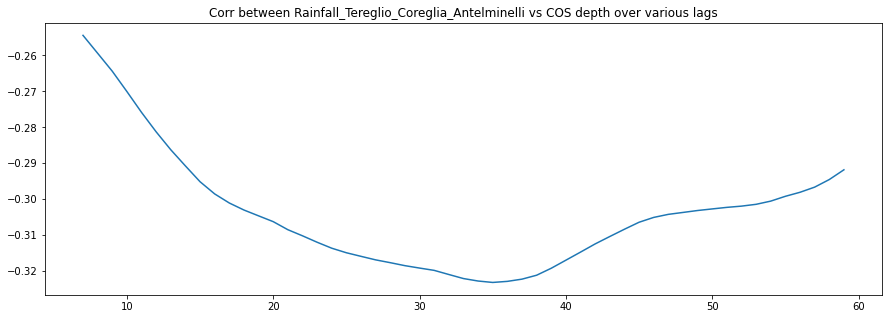

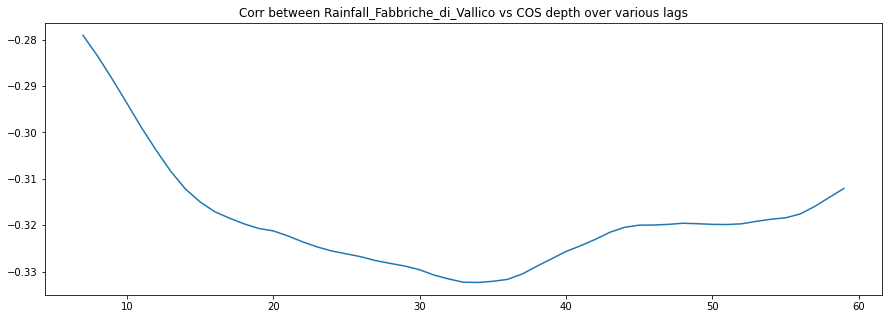

In [41]:
for i in range(len(corr_rain)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,60), corr_rain[i])
    plt.title('Corr between ' +rain_cols[i]+ ' vs COS depth over various lags');

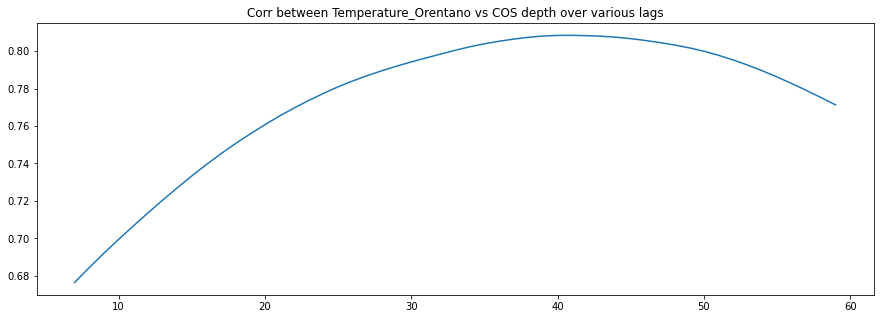

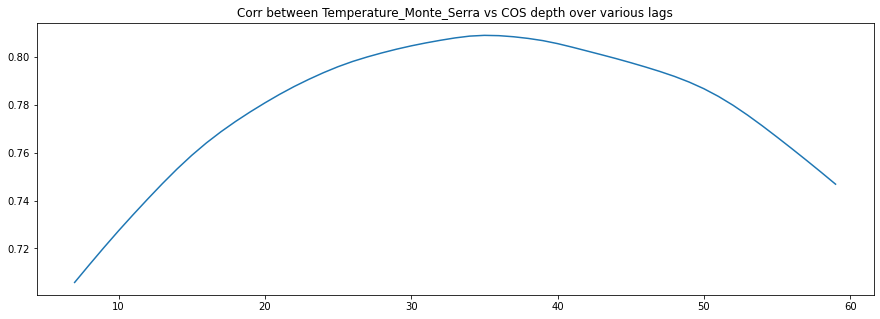

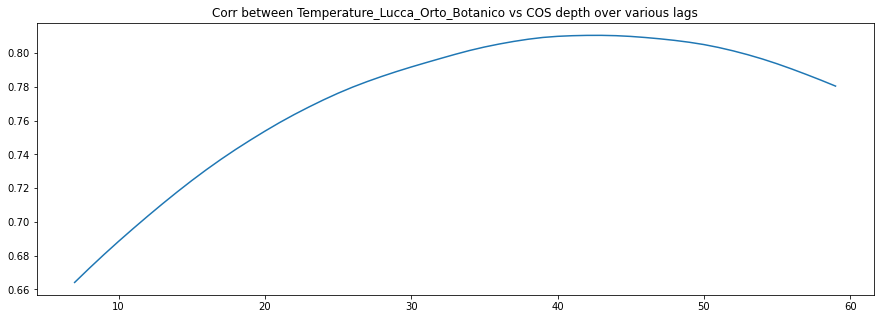

In [42]:
for i in range(len(corr_temp)):
    plt.figure(figsize=(15,5))
    plt.plot(range(7,60), corr_temp[i])
    plt.title('Corr between ' +temp_cols[i]+ ' vs COS depth over various lags');

In [43]:
temp_shifts = {}
for i in range(len(corr_temp)):
    temp_shifts[temp_cols[i]] = corr_temp[i].index(max(corr_temp[i]))+7

rain_shifts = {}
for i in range(len(corr_rain)):
    rain_shifts[rain_cols[i]] = corr_rain[i].index(min(corr_rain[i]))+7 

In [44]:
for k, v in temp_shifts.items():
    aus_cos[k] = aus_cos[k].shift(v)
    
for k, v in rain_shifts.items():
    aus_cos[k] = aus_cos[k].shift(v)

In [45]:
other_cols = [col for col in rollers_lt2 if "Temperature" not in col and "Rainfall" not in col]

for col in other_cols:
    aus_cos[col]=aus_cos[col].shift(7)

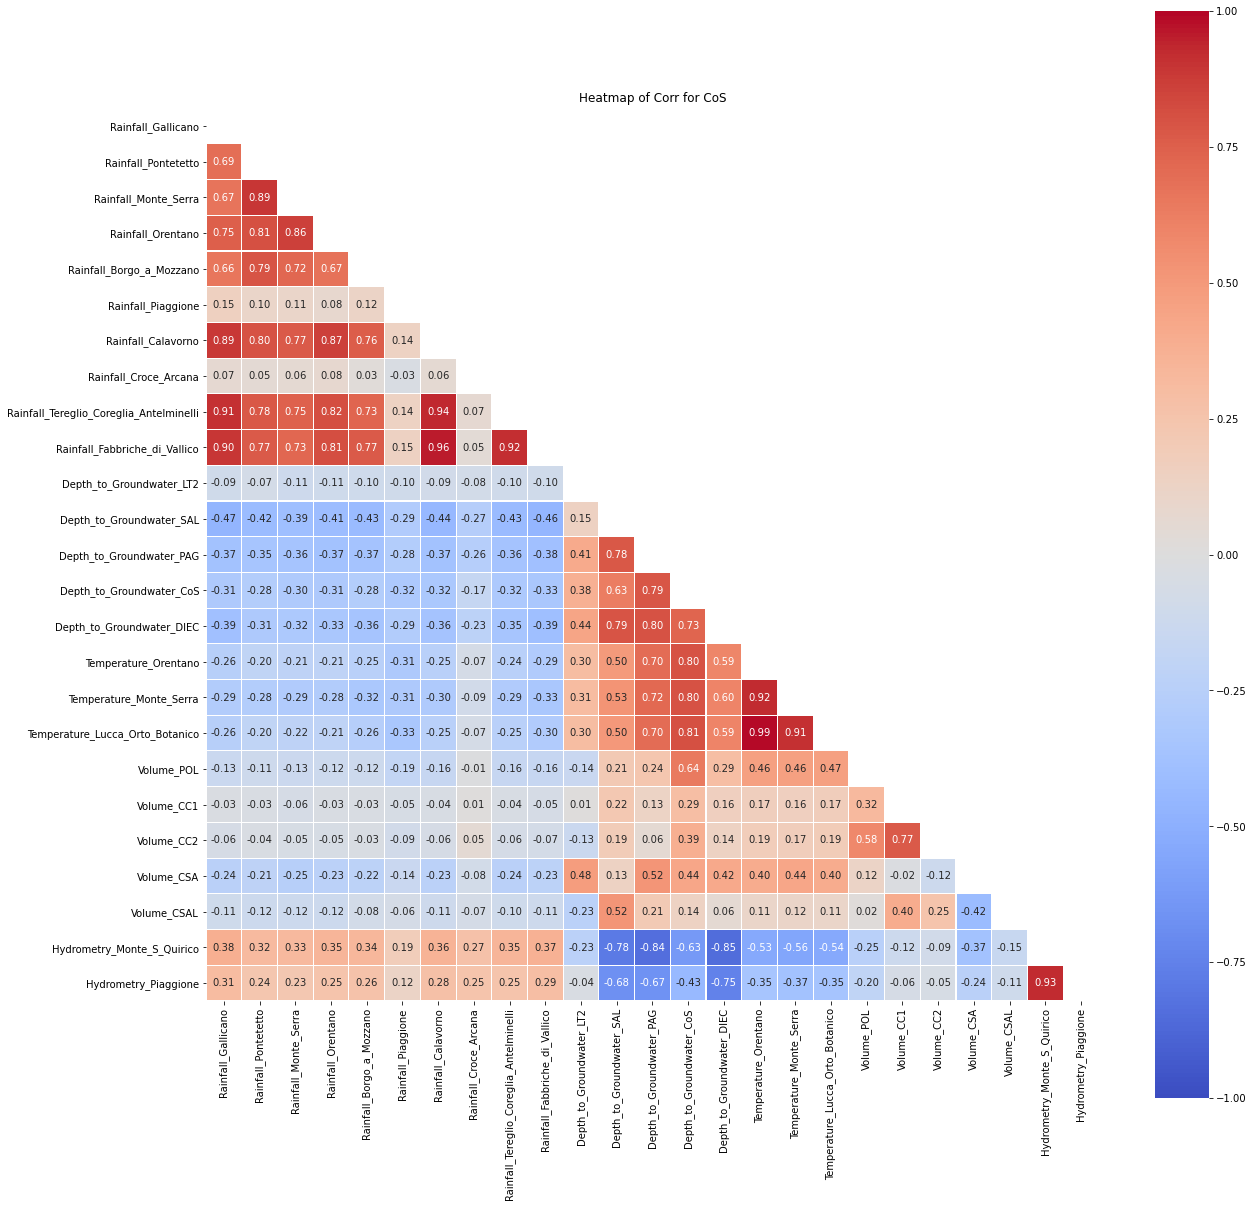

In [46]:
heat(aus_cos, 'CoS')

- Most of the features require a shift of around 35 days with Depth at CoS as the targeted variable. 


- Depth at CoS correlates well with the temperature readings and the other depth measurements except LT2. Moderate correlations were also observed with hydrometry, as well as, most of the Rainfall and Volume features except for the Volume of water drawn at CSAL.

## Modeling and Evaluation

In [47]:
dfs = [aus_lt2, aus_sal, aus_cos]

In [48]:
for df in dfs:
    df.dropna(inplace=True)
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['mnth_sin'] = np.sin((df.month-1)*(2.*np.pi/12)) # cyclical encoding for months
    df['mnth_cos'] = np.cos((df.month-1)*(2.*np.pi/12)) # cyclical encoding for months
    df.drop('month', axis=1, inplace = True)

### LT2

In [49]:
X = aus_lt2.drop('Depth_to_Groundwater_LT2', axis=1)
y = aus_lt2['Depth_to_Groundwater_LT2']
# Separating the features from the target variable

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# shuffle set to false instead of a random split since there is a time element to this model which is meant for forecasts

In [51]:
X_train.tail()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-14,0.171429,1.252966e-14,0.885714,0.0,0.771429,0.457143,0.657143,0.714286,1.314286,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.225714,-0.965714,2018,-0.5,0.866025
2018-12-15,0.171429,1.252966e-14,0.885714,0.0,0.828571,0.457143,0.657143,0.714286,1.314286,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.238571,-0.962857,2018,-0.5,0.866025
2018-12-16,0.171429,5.714286e-02,0.028571,0.0,0.828571,0.457143,0.657143,0.742857,1.314286,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.248571,-0.960000,2018,-0.5,0.866025
2018-12-17,0.171429,5.714286e-02,0.028571,0.0,0.828571,0.457143,0.657143,0.742857,1.314286,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.248571,-0.967143,2018,-0.5,0.866025
2018-12-18,0.200000,5.714286e-02,0.028571,0.0,0.828571,0.857143,0.657143,0.714286,1.314286,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.245714,-0.971429,2018,-0.5,0.866025


In [52]:
X_test.head()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-19,0.200000,0.057143,0.028571,0.000000,0.828571,0.857143,0.657143,0.771429,1.142857e+00,0.571429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.245714,-0.971429,2018,-0.5,0.866025
2018-12-20,0.114286,0.228571,0.600000,0.342857,0.828571,0.400000,0.200000,0.657143,2.410770e-14,0.200000,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.242857,-0.972857,2018,-0.5,0.866025
2018-12-21,0.028571,0.228571,0.600000,0.371429,0.057143,0.400000,0.000000,0.142857,2.857143e-02,0.000000,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.242857,-0.974286,2018,-0.5,0.866025
2018-12-22,2.885714,0.228571,0.600000,0.371429,0.000000,1.028571,0.428571,0.142857,5.714286e-01,0.342857,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.228571,-0.978571,2018,-0.5,0.866025
2018-12-23,2.914286,0.171429,0.571429,0.371429,0.657143,1.028571,0.542857,0.114286,5.714286e-01,0.371429,...,6360.69765,16417.981029,10653.373029,6366.232028,3261.279493,0.214286,-0.981429,2018,-0.5,0.866025


In [53]:
ss = StandardScaler()

In [54]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
# Standard Scaling the features

In [55]:
# Initializing the regressor to be used
sgd = SGDRegressor(random_state = 42)

In [56]:
# Params for GridSearching
gs_params = {
    'loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.01, 0.1, 1]
}

In [57]:
# Initializing the GridSearch
gs = GridSearchCV(sgd,
                  param_grid = gs_params,
                  scoring = 'neg_root_mean_squared_error',
                  cv=5)

In [58]:
gs.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

In [59]:
gs.best_params_

{'alpha': 0.1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}

In [60]:
-gs.best_score_

0.2747026391716617

In [61]:
-gs.score(X_train_scaled, y_train)

0.19113656152232392

In [62]:
-gs.score(X_test_scaled, y_test)

0.2535815319320526

In [63]:
-gs.score(X_test_scaled, y_test)/1.037100
# dividing by standard deviation of column from first notebook

0.24451020338641655

A decent RMSE of 0.25 is achieved which is 24% of the standard deviation.

There is some slight overfitting since the RMSE on the test data is slightly higher than the train data.

In [64]:
feat_coeffs = pd.DataFrame({'Feature': [c for c in X_train.columns], 'Coefficient': gs.best_estimator_.coef_})
feat_coeffs.sort_values('Coefficient')

,Feature,Coefficient
25,mnth_sin,-0.109049
0,Rainfall_Gallicano,0.000000
23,Hydrometry_Piaggione,0.000000
22,Hydrometry_Monte_S_Quirico,0.000000
21,Volume_CSAL,0.000000
20,Volume_CSA,0.000000
19,Volume_CC2,0.000000
18,Volume_CC1,0.000000
17,Volume_POL,0.000000
11,Depth_to_Groundwater_PAG,0.000000


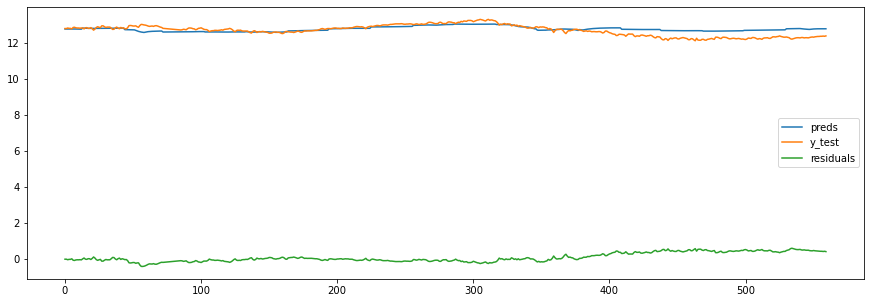

In [65]:
plt.figure(figsize=(15,5))
plt.plot(gs.predict(X_test_scaled))
plt.plot(y_test.values)
plt.plot(gs.predict(X_test_scaled) - y_test.values)
plt.legend(['preds', 'y_test', 'residuals']);

- The strongest predictors are found to be the year and the month. Depth at CoS and DIEC also had some influence. A large number of the features were deemed irrelevant based on the application of the L1 penalty.


- The magnitude of the residual can be seen to increase slightly over time. Since the year and month are among the stronger predictors, it follows that the error in the predictions are likely increase as the predictions are made on dates further away that those the model had been trained on. As such, it would be prudent to retrain the model with the latest data at suitable intervals.


- Since the temperature and rainfall features had little to no effect on the Depth at LT2, it could be possible that the locations from which these data were obtained were not within the vicinity of location that the target variable was measured. Additional data may be required to develop a better model

### SAL (repeating the same modeling and evaluation process that was done for LT2)

In [66]:
X = aus_sal.drop('Depth_to_Groundwater_SAL', axis=1)
y = aus_sal['Depth_to_Groundwater_SAL']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [68]:
X_train.tail()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-16,19.171429,17.314286,22.428571,16.314286,28.542857,24.428571,21.457143,7.542857,3.657143,7.828571,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.258571,-1.031429,2018,-0.866025,0.5
2018-11-17,9.571429,17.200000,17.142857,13.114286,24.485714,21.457143,6.485714,8.057143,3.885714,3.885714,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.234286,-1.018571,2018,-0.866025,0.5
2018-11-18,10.400000,14.085714,9.371429,5.142857,6.400000,5.571429,7.314286,8.514286,3.800000,5.257143,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.217143,-1.005714,2018,-0.866025,0.5
2018-11-19,6.514286,5.542857,11.485714,5.914286,7.114286,6.628571,5.600000,8.400000,2.628571,4.971429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.207143,-0.992857,2018,-0.866025,0.5
2018-11-20,6.514286,7.228571,8.914286,3.914286,5.285714,4.885714,5.342857,7.142857,1.371429,4.000000,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.200000,-0.987143,2018,-0.866025,0.5


In [69]:
X_test.head()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-21,2.600000,5.971429,8.428571,3.457143,5.228571,4.857143,2.857143,3.742857,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.187143,-0.988571,2018,-0.866025,0.5
2018-11-22,2.828571,5.914286,3.771429,2.142857,2.914286,2.571429,3.971429,4.000000,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.177143,-0.990000,2018,-0.866025,0.5
2018-11-23,2.085714,2.685714,4.428571,2.428571,4.114286,3.942857,3.142857,3.000000,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.174286,-0.991429,2018,-0.866025,0.5
2018-11-24,1.514286,3.457143,4.342857,2.200000,3.885714,3.828571,2.428571,2.485714,0.028571,1.600000,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.171429,-0.997143,2018,-0.866025,0.5
2018-11-25,0.314286,3.371429,3.142857,1.200000,3.000000,2.971429,1.314286,1.400000,0.028571,0.228571,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.164286,-1.001429,2018,-0.866025,0.5


In [70]:
ss = StandardScaler()

In [71]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [72]:
sgd = SGDRegressor(random_state = 42)

In [73]:
gs_params = {
    'loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.01, 0.1, 1]
}

In [74]:
gs = GridSearchCV(sgd,
                  param_grid = gs_params,
                  scoring = 'neg_root_mean_squared_error',
                  cv=5)

In [75]:
gs.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

In [76]:
gs.best_params_

{'alpha': 0.1, 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet'}

In [77]:
-gs.best_score_

0.17314235985929552

In [78]:
-gs.score(X_train_scaled, y_train)

0.1269082159569333

In [79]:
-gs.score(X_test_scaled, y_test)

0.12317248460281484

In [80]:
-gs.score(X_test_scaled, y_test)/0.642939
# dividing by standard deviation of column from first notebook

0.19157724854584157

A decent RMSE of 0.12 is achieved which is 19% of the standard deviation.

There is some slight underfitting since the RMSE on the train data is slightly higher than the test data.

In [81]:
feat_coeffs = pd.DataFrame({'Feature': [c for c in X_train.columns], 'Coefficient': gs.best_estimator_.coef_})
feat_coeffs.sort_values('Coefficient')

,Feature,Coefficient
22,Hydrometry_Monte_S_Quirico,-0.140364
10,Depth_to_Groundwater_LT2,-0.021828
17,Volume_POL,-0.021569
1,Rainfall_Pontetetto,-0.019401
20,Volume_CSA,-0.018721
3,Rainfall_Orentano,-0.013320
26,mnth_cos,-0.013109
23,Hydrometry_Piaggione,-0.011169
7,Rainfall_Croce_Arcana,-0.004301
8,Rainfall_Tereglio_Coreglia_Antelminelli,0.000000


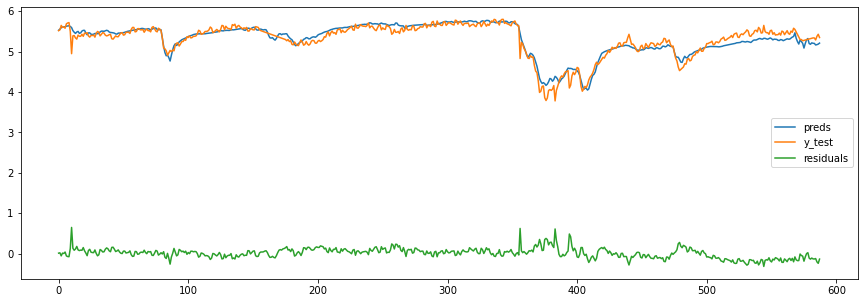

In [82]:
plt.figure(figsize=(15,5))
plt.plot(gs.predict(X_test_scaled))
plt.plot(y_test.values)
plt.plot(gs.predict(X_test_scaled) - y_test.values)
plt.legend(['preds', 'y_test', 'residuals']);

- The strongest predictors are found to be the year, the Depth measured at DIEC, the Hydrometry measurement at Monte_S_Quirico and the Volume of water drawn at CSAL. A number of predictors were deemed irrelevant as well since the Elastic Net combines the use of both L1 and L2 penalties.


- The magnitude of the residual can be seen to increase slightly over time as the predictions are made on dates further away that those the model had been trained on. As such, it would be prudent to retrain the model with the latest data at suitable intervals.

### CoS (repeating the same modeling and evaluation process that was done for the previous 2)

In [83]:
X = aus_sal.drop('Depth_to_Groundwater_CoS', axis=1)
y = aus_sal['Depth_to_Groundwater_CoS']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [85]:
X_train.tail()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-16,19.171429,17.314286,22.428571,16.314286,28.542857,24.428571,21.457143,7.542857,3.657143,7.828571,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.258571,-1.031429,2018,-0.866025,0.5
2018-11-17,9.571429,17.200000,17.142857,13.114286,24.485714,21.457143,6.485714,8.057143,3.885714,3.885714,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.234286,-1.018571,2018,-0.866025,0.5
2018-11-18,10.400000,14.085714,9.371429,5.142857,6.400000,5.571429,7.314286,8.514286,3.800000,5.257143,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.217143,-1.005714,2018,-0.866025,0.5
2018-11-19,6.514286,5.542857,11.485714,5.914286,7.114286,6.628571,5.600000,8.400000,2.628571,4.971429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.207143,-0.992857,2018,-0.866025,0.5
2018-11-20,6.514286,7.228571,8.914286,3.914286,5.285714,4.885714,5.342857,7.142857,1.371429,4.000000,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.200000,-0.987143,2018,-0.866025,0.5


In [86]:
X_test.head()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione,year,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-21,2.600000,5.971429,8.428571,3.457143,5.228571,4.857143,2.857143,3.742857,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.187143,-0.988571,2018,-0.866025,0.5
2018-11-22,2.828571,5.914286,3.771429,2.142857,2.914286,2.571429,3.971429,4.000000,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.177143,-0.990000,2018,-0.866025,0.5
2018-11-23,2.085714,2.685714,4.428571,2.428571,4.114286,3.942857,3.142857,3.000000,1.371429,1.571429,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.174286,-0.991429,2018,-0.866025,0.5
2018-11-24,1.514286,3.457143,4.342857,2.200000,3.885714,3.828571,2.428571,2.485714,0.028571,1.600000,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.171429,-0.997143,2018,-0.866025,0.5
2018-11-25,0.314286,3.371429,3.142857,1.200000,3.000000,2.971429,1.314286,1.400000,0.028571,0.228571,...,6865.6965,15671.670171,10532.4192,6174.148334,3674.762857,0.164286,-1.001429,2018,-0.866025,0.5


In [87]:
ss = StandardScaler()

In [88]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [89]:
sgd = SGDRegressor(random_state = 42)

In [90]:
gs_params = {
    'loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.01, 0.1, 1]
}

In [91]:
gs = GridSearchCV(sgd,
                  param_grid = gs_params,
                  scoring = 'neg_root_mean_squared_error',
                  cv=5)

In [92]:
gs.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

In [93]:
gs.best_params_

{'alpha': 0.1, 'loss': 'epsilon_insensitive', 'penalty': 'l2'}

In [94]:
-gs.best_score_

0.4049999990502541

In [95]:
-gs.score(X_train_scaled, y_train)

0.26800899099875136

In [96]:
-gs.score(X_test_scaled, y_test)

0.569282297437768

In [97]:
-gs.score(X_test_scaled, y_test)/1.379046
# standard deviation of column from first notebook

0.4128087804451541

A RMSE of 0.57 is achieved which is 41% of the standard deviation.

In [98]:
feat_coeffs = pd.DataFrame({'Feature': [c for c in X_train.columns], 'Coefficient': gs.best_estimator_.coef_})
feat_coeffs.sort_values('Coefficient')

,Feature,Coefficient
25,mnth_sin,-0.185682
22,Hydrometry_Monte_S_Quirico,-0.152032
24,year,-0.117406
18,Volume_CC1,-0.114925
6,Rainfall_Calavorno,-0.045600
3,Rainfall_Orentano,-0.016281
5,Rainfall_Piaggione,0.006998
7,Rainfall_Croce_Arcana,0.009240
1,Rainfall_Pontetetto,0.010612
15,Temperature_Monte_Serra,0.020283


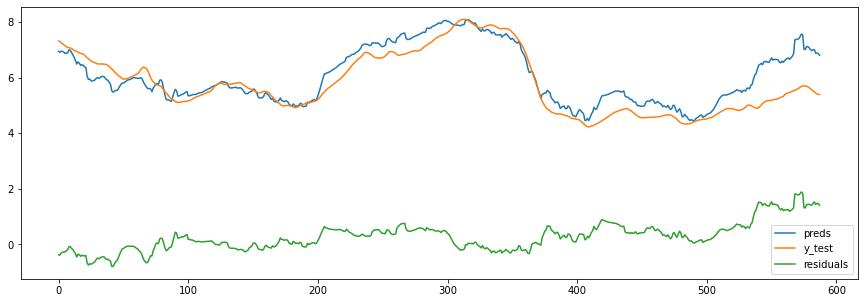

In [99]:
plt.figure(figsize=(15,5))
plt.plot(gs.predict(X_test_scaled))
plt.plot(y_test.values)
plt.plot(gs.predict(X_test_scaled) - y_test.values)
plt.legend(['preds', 'y_test', 'residuals']);

- The strongest predictors are found to be the Depth measured at PAG and the Volume of water drawn at POL. Since an L2 penalty was applied by the Gridsearch, all the features had some weightage significance in model.


- The magnitude of the residual can be seen to increase slightly over time as the predictions are made on dates further away that those the model had been trained on. As such, it would be prudent to retrain the model with the latest data at suitable intervals.


- It is further observed that the predictions toward the end (from around Mar 2020) had diverged significantly from the test data. It was also observed in the first notebook that the increase in Depth at CoS from the start of 2020 to the middle of the year was significantly less than all the previous years that data was available for. This could be due to changes in human behavior brought about by COVID-19 or possible instrument malfunction since there were some zero values in the original dataset for this period as well.

In [100]:
-gs.score(X_test_scaled[:-100], y_test[:-100])

0.3836046474786793

In [101]:
-gs.score(X_test_scaled[:-100], y_test[:-100])/1.379046

0.2781666800662772

Excluding the last 100 days of data gives a significantly improved RMSE of 0.38 which is 28% of the standard deviation

## Conclusion

The GridSearch ran over various params for the SGDRegressor models had varying degrees of success in predicting the depth to groundwater at the three target locations of LT2, SAL and CoS. Of the models, predicting the depth at SAL had the best RMSE scores while predicting the depth at CoS fared the poorest among the regressors. A SARIMA model was also attempted for depth at SAL which performed worse than all the regression models in terms of RMSE.

It was noted that the month and year were rather strong predictors for LT2 as opposed to any of the other variables like volume drawn, temperature, rainfall and water measurements at other locations. 

It was also observed that the predictions and the test data diverged significantly for the depth at CoS with some of the possible causes theorized above.

Nonetheless, predicting the water level to be within an error margin of 25cm, 12cm and 38cm for the depths at LT2, SAL and CoS respectively represents a reasonable degree of success if compared to the original standard deviation as a baseline.

## Recommendation

The success of the regressor model in predicting the depth at SAL shows that regression with features such as water level measurements at nearby locations, rainfall measurements, temperature measurements and metering the volume of water drawn can play a vital role in predicting water availability.

Nonetheless, it was observed that these features had little importance when it came to predicting LT2. It was also noted from the background information given in Kaggle by the competition host that the Auser waterbody is split into North and South with the levels of the north sector being represented by the values of the SAL, PAG, CoS and DIEC wells, while the levels of the south sector by the LT2 well. It could be possible that the majority of the predictor variables in the dataset given were mainly from the north sector. In such a case, additional data collection from the south sector is required to proceed further. An alternative means to this would be a time series approach whereby the predicted variable is predicted solely based on past values.

As mentioned, the data points in the last few months of the dataset for the depth at CoS seems to be uncharacteristic when compared to trends from previous years. Further study on this is necessary to identify the reason why before a better model can be built.

One final recommendation for all the models would be to retrain them periodically at a suitable interval depending on the level of accuracy required by the user.